In [4]:
import roboticstoolbox as rtb
from roboticstoolbox import ET # ET - elementary transform
from spatialmath import SE3
import swift
import matplotlib.pyplot as plt
import numpy as np
from roboticstoolbox.backends.PyPlot import PyPlot2
import open3d as o3d

In [5]:
def plotFrames(frames):
    i = 0 
    for frame in frames:
        try:
            frame.plot(frame=f"{i}")
            i+=1
        except:
            pass
    plt.show()

In [3]:
%matplotlib inline 
T0,T1,T2,T3,T4 = None,None,None,None,None
fig = plt.figure()

plotFrames([T0,T1,T2,T3,T4])

<Figure size 640x480 with 0 Axes>

In [4]:
import roboticstoolbox as rtb
import swift
import numpy as np
# env = swift.Swift()
# realtime runs as quick as realtime as possible
# env.launch()

ur = rtb.models.DH.UR5()
print(ur.qlim)
# ur5 = rtb.models.UR5()
# home pose
qHome = np.array(np.radians([0,-43.5,103,119.7,-90.4,66.5]))
ur.qr = qHome
ur.fkine(qHome)
SE3().plot()
ur.plot(ur.qr)

[[-3.14159265 -3.14159265 -3.14159265 -3.14159265 -3.14159265 -3.14159265]
 [ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PyPlot3D backend, t = 0.05, scene:
  UR5

In [140]:
T = ur.fkine(qHome) # end-effector frame (camera/pose)======================

In [215]:
from roboticstoolbox import ET # ET - elementary transform
from spatialmath import SO3
e = ET.Rz() * ET.tx(1) * ET.Rz() * ET.tx(1)
q = np.array(np.radians([0,0]))
T_N = e.fkine(q) # T_N - end-effector frame (before optoforce/gripper)
print(f"T_N:\n{T_N}")
# distance between end-effector origin and center of camera along z-axis
d = 0.2
P_C = np.array([0,0,d]) # Translation from frame T_n to origin of camera frame

theta = np.radians(90) # Rotation in degrees about the Z-axis between the camera frame and end-effector frame
R = SO3.Rz(theta) # Rotation from frame N to frame C

# Rotate the frame (basis-vectors of frame N) to get the basis vectors for frame C
R_C = SO3(np.array(T_N)[0:3,0:3].T) * R
print(f"R_C:\n{R_C}")

# multiply each scaling factor of P_C by the respective basis vector in T_N to get the origin of the camera frame {C}
# P_C * np.array([[1,0,0],[0,1,0],[0,0,1]])

# Transform corresponding to camera frame (with some of my own work/derivations)
T_C = T_N * SE3.Tz(d) * SE3(R_C)

# Fully in spatial math
T_C = T_N * SE3.Tz(d) * SE3.Rz(theta)

print(f"T_C:\n{T_C}")

T_N:
   1         0         0         2         
   0         1         0         0         
   0         0         1         0         
   0         0         0         1         

R_C:
   0        -1         0         
   1         0         0         
   0         0         1         

T_C:
   0        -1         0         2         
   1         0         0         0         
   0         0         1         0.2       
   0         0         0         1         



In [176]:
print()
# T_N = np.array([[1,0,0,2],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

[[       1        0        0]
 [       0        1        0]
 [       0        0        1]]


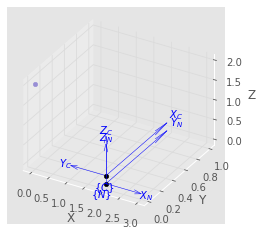

In [239]:
# fig = plt.figure()
T_N.plot(frame="N")
T_C.plot(frame="C")
ax = plt.gca()
ax.scatter([0],[0],[2])

In [ ]:


np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

ur5 = rtb.models.DH.UR5()
homePose = np.array(np.radians([53.12,-112.14,144.11,-27.45,55.00,171.68]))
ur5.q = homePose

# env = ur5.plot(ur5.q) # PyPlot backend
T_N = ur5.fkine(ur5.q) # T_N - end-effector frame (before optoforce/gripper)
# T_N.plot(frame="N",length=0.1)
d = 3 # distance between end-effector frame origin and center of camera frame along z-axis (m)
P_C = np.array([0,0,d]) # Translation from frame T_N to origin of camera frame (m)
# theta = np.radians(90) # Rotation about the Z-axis between the camera frame and end-effector frame (None,)
T_C = T_N # * SE3.Tz(d) # * SE3.Rz(theta) # Camera coordinate frame
# T_C.plot(frame="C",length=0.1)
# env.hold() 
'''
meshFrames = [] # frames for open3d
urFrames = ur5.fkine_all(ur5.q) # spatial math list of SE3 link frames

for T_i in urFrames:
    # transforms each T_i into open3d coordinate system
    # +x right, +y down, +z forward
    # T_i = T_i * SE3.Rx(np.radians(90)) * SE3.Rz(np.radians(180))
    linkFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3)
    linkFrame.transform(np.array(T_i))
    meshFrames.append(linkFrame)


baseSphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.025)
baseFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
cameraFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
cameraFrame.transform(np.array(T_C)) # relative = false
meshFrames.extend([baseFrame,cameraFrame,baseSphere])
'''
T_C = T_C * SE3.Rx(np.radians(90)) * SE3.Rz(np.radians(180))
camFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
camFrame.transform(T_C)
pcd = o3d.io.read_point_cloud("front1.ply")
meshFrames = [camFrame]
meshFrames.extend([pcd])
print(T_C)
print(camFrame.get_center())
o3d.visualization.draw(meshFrames)
